# 8: Building Your 3D Vision Pipeline

As we now are comming to an end of this series, we have covered a lot of ground. We have learned about the basics of 3D vision, the first half we covered a singel camera; How to model a camera, how to project 3D points into 2D and how to estimate a pose from 2D-3D correspondences. In the second half we covered stereo vision; How to model two cameras compared to each other, how to triangulate 3D points from two 2D points, epipolar geometry and stereo matching.

For the final workshop we will try to put the tools we have made into a full 3D stereo matching pipeline.

## 3D Stereo Matching Pipeline

To make a complete pipeline we will combine from all the previous workshops. We start by loading test data, 

:::{admonition} Dataset
:class: tip, dropdown
In this workshop we will use the Middlebury Stereo Evaluation dataset. The dataset can be seen here:

- [2021 Mobile stereo datasets with ground truth](https://vision.middlebury.edu/stereo/data/scenes2021/)
- [Download all as zip](https://vision.middlebury.edu/stereo/data/scenes2021/zip/all.zip)

Only the dataset "traproom1" is included in this repository. You can download the rest using the zip link above. To make it seamlessly integrate with repo by:

- Placing the desired scene folders in the `test_data` folder.
- Add the dataset to `TestDataPaths` similar to that of `traproom1`:
    ```python
    class TestDataPaths:
        ...
        traproom1_dir: Path = _test_data_dir / "traproom1"
        your_folder_dir: Path = _test_data_dir / "your_folder"
    ```
:::

In [1]:
import matplotlib.pyplot as plt
import numpy as np


from oaf_vision_3d._notebook_tools import simple_plot
from oaf_vision_3d._test_data_paths import TestDataPaths
from oaf_vision_3d.block_matching import block_matching
from oaf_vision_3d.plane_sweeping import plane_sweeping
from oaf_vision_3d.point_cloud_visualization import open3d_visualize_point_cloud
from oaf_vision_3d._stereo_data_reader import StereoData
from oaf_vision_3d.triangulation import triangulate_disparity

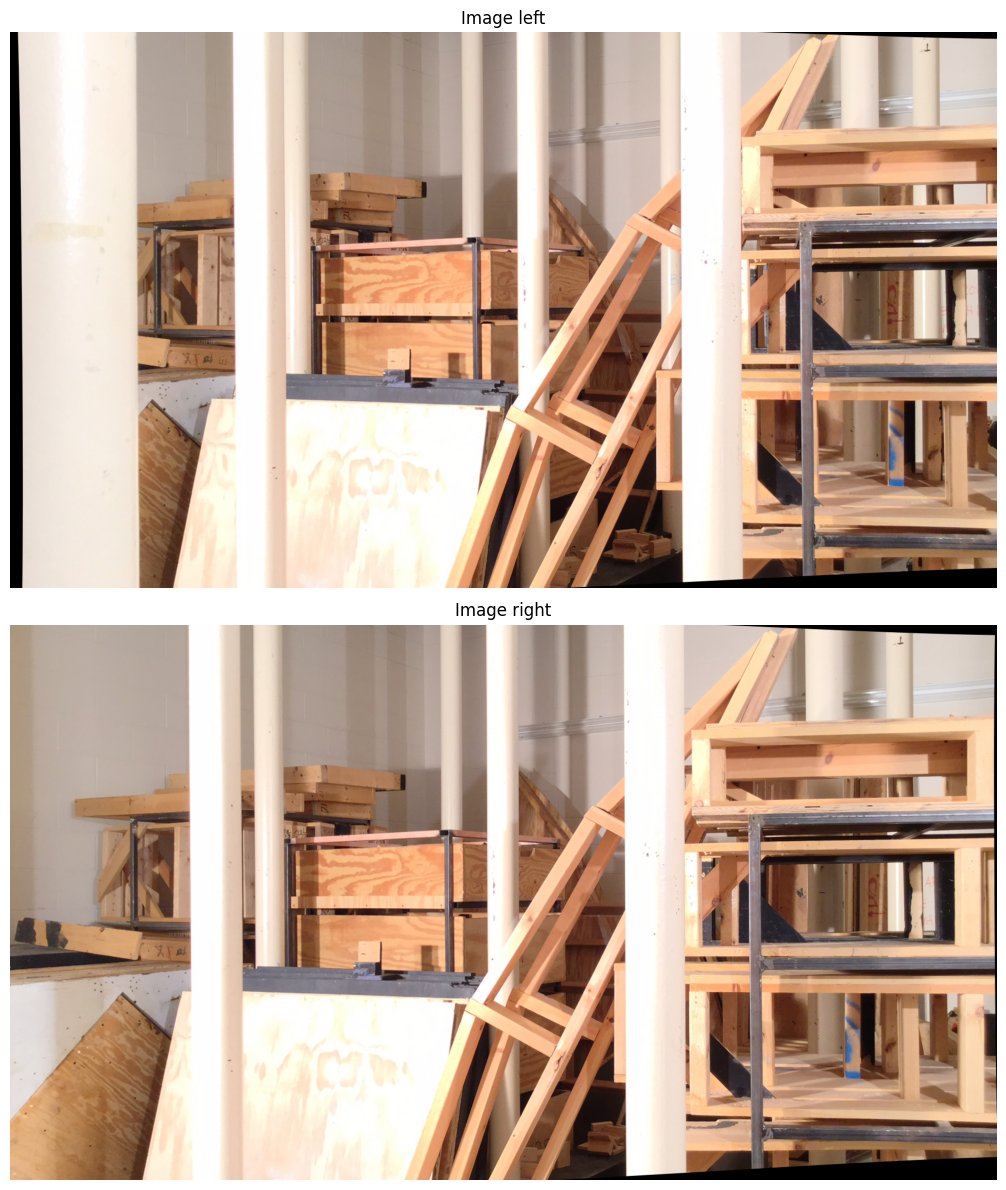

In [2]:
data_dir = TestDataPaths.traproom1_dir
stereo_data = StereoData.from_path(data_dir)
rgb = stereo_data.image_0

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].imshow(stereo_data.image_0, cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Image left")
ax[0].axis("off")
ax[1].imshow(stereo_data.image_1, cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Image right")
ax[1].axis("off")
plt.tight_layout()
plt.show()

### Block Matching

We can perform block matching on the stereo images to get a disparity map using the [`block_matching`](../oaf_vision_3d/block_matching.py) module that we implemented in [workshop 6](./06_stereo_matching_fundamentals.ipynb).

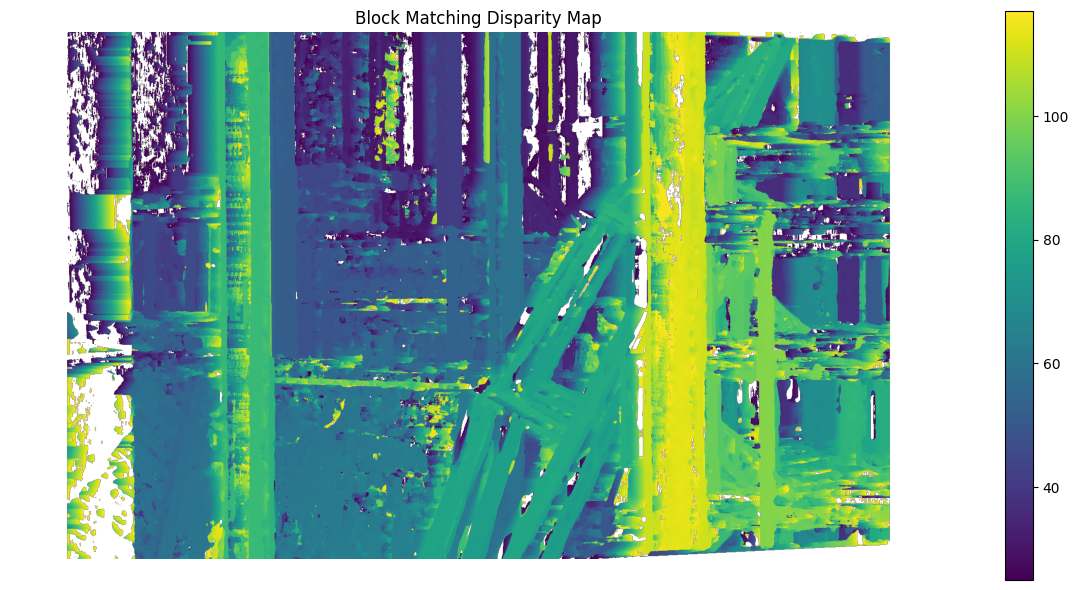

In [3]:
disparity_map = block_matching(
    image_0=stereo_data.image_0,
    image_1=stereo_data.image_1,
    disparity_range=stereo_data.expected_disparity,
    block_size=np.array([11, 11], dtype=np.int32),
)
simple_plot(data=disparity_map, title="Block Matching Disparity Map")

From the dispariries we can triangualte a depth map using the triangulation math from [workshop 5](./05_dual_camera_setups.ipynb). The function [`triangulate_disparity`] that we made in [workshop 6](./06_stereo_matching_fundamentals.ipynb) can be used to triangulate the disparity map:

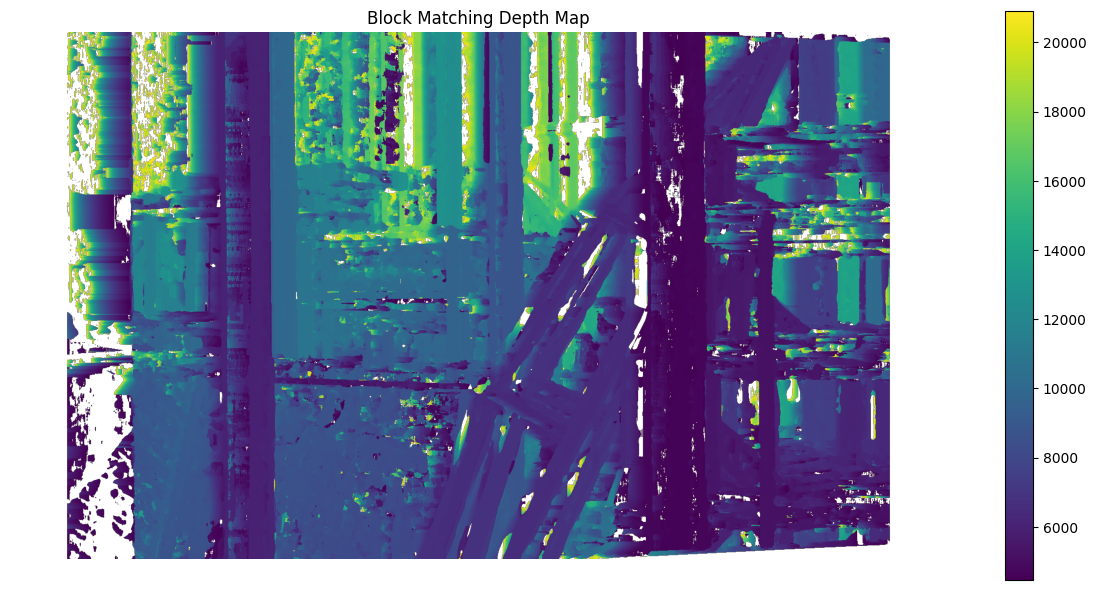

In [4]:
xyz_block_mathcing = triangulate_disparity(
    disparity=disparity_map,
    lens_model_0=stereo_data.lens_model_0,
    lens_model_1=stereo_data.lens_model_1,
    transformation_matrix=stereo_data.transformation_matrix,
)
if xyz_block_mathcing is not None:
    simple_plot(data=xyz_block_mathcing[..., 2], title="Block Matching Depth Map")

In [5]:
if xyz_block_mathcing is not None:
    open3d_visualize_point_cloud(xyz=xyz_block_mathcing, rgb=rgb)

Does not exist


### Plane Sweeping

In [workshop 7](./07_stereo_matching_fundamentals_continued.ipynb) we looked at how plane sweeping as an alternative way to do block matching. We can use the function `plane_sweeping` from the [`plane_sweeping`](../oaf_vision_3d/plane_sweeping.py) module to get the xyz values directly:

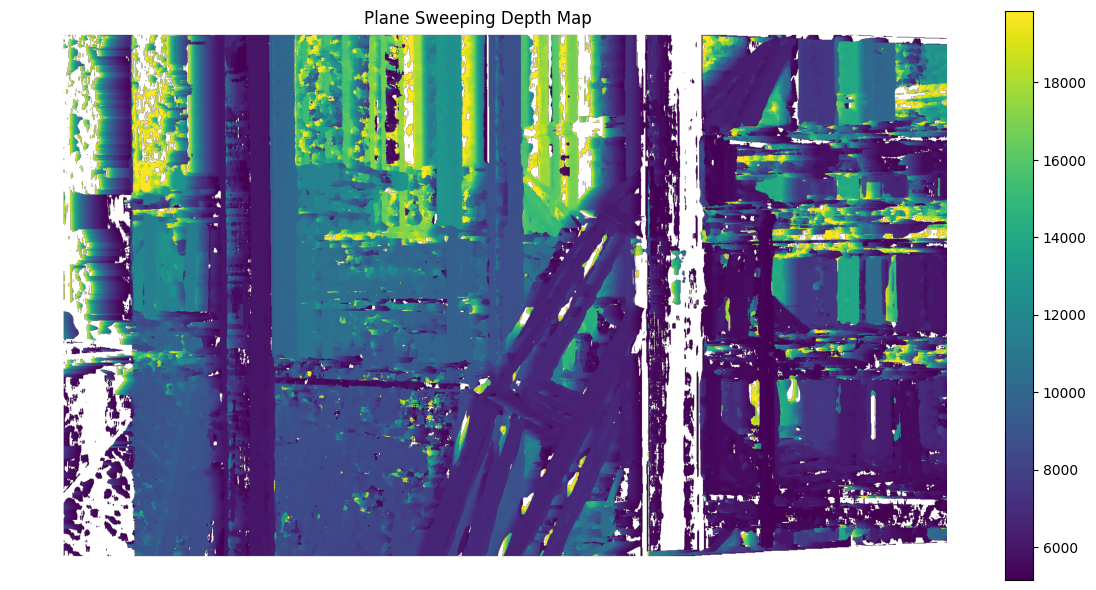

In [7]:
xyz_plane_sweeping = plane_sweeping(
    image=stereo_data.image_0,
    lens_model=stereo_data.lens_model_0,
    secondary_images=[stereo_data.image_1],
    secondary_lens_models=[stereo_data.lens_model_1],
    secondary_transformation_matrices=[stereo_data.transformation_matrix],
    depth_range=np.array([5000, 20000], dtype=np.float32),
    step_size=150.0,
    block_size=11,
)
if xyz_plane_sweeping is not None:
    simple_plot(data=xyz_plane_sweeping[..., 2], title="Plane Sweeping Depth Map")

In [8]:
if xyz_plane_sweeping is not None:
    open3d_visualize_point_cloud(xyz=xyz_plane_sweeping, rgb=rgb)

Does not exist


An added advantage of plane sweeping is that it does not limit us to a stereo camera setup, in fact, we can use any number of cameras to get the depth map. This uses the constrains given by the calibration of the cameras to match agains all images at the same time. We can show this of on the following dataset:

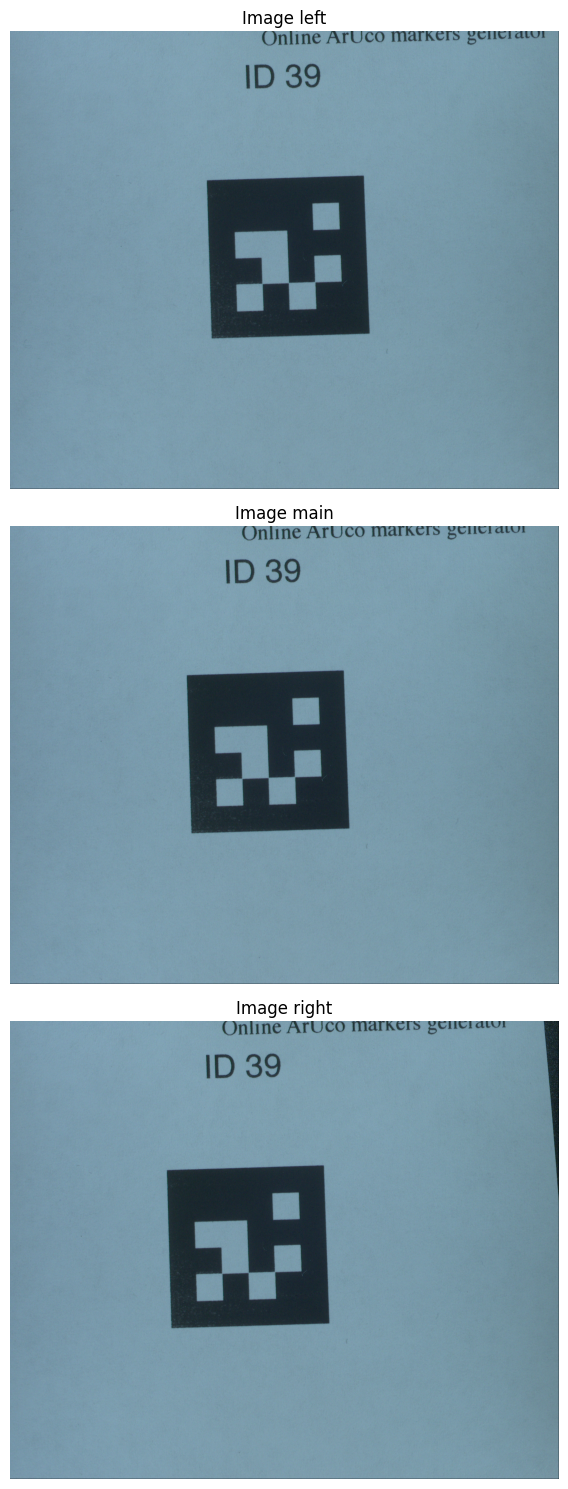

In [9]:
stereo_data_0 = StereoData.from_path(TestDataPaths.stereo_data_0_dir)
stereo_data_1 = StereoData.from_path(TestDataPaths.stereo_data_1_dir)

fig, ax = plt.subplots(3, 1, figsize=(12, 15))
ax[0].imshow(stereo_data_1.image_1, cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Image left")
ax[0].axis("off")
ax[1].imshow(stereo_data_0.image_0, cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Image main")
ax[1].axis("off")
ax[2].imshow(stereo_data_0.image_1, cmap="gray", vmin=0, vmax=1)
ax[2].set_title("Image right")
ax[2].axis("off")
plt.tight_layout()
plt.show()

We run the same plane sweeping algorithm, but now giving both the left and right images as secondary images:

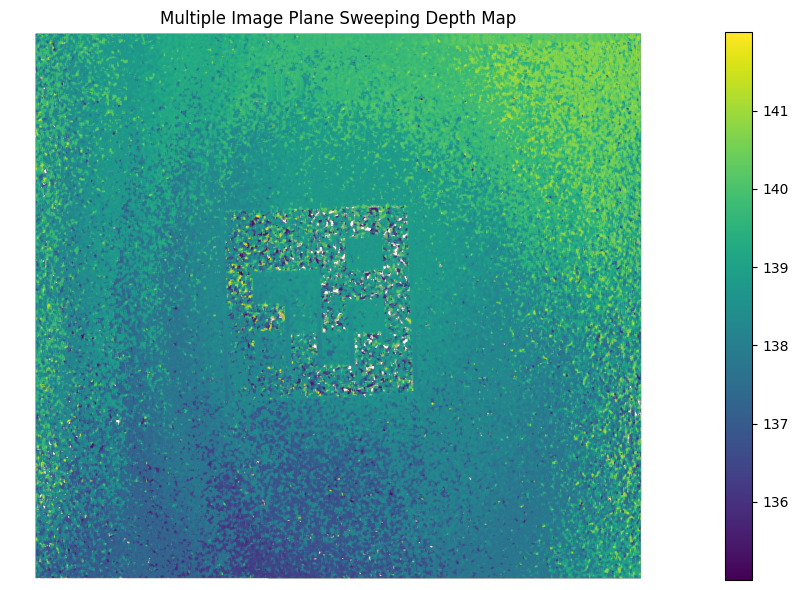

In [11]:
xyz_plane_sweeping_multiple = plane_sweeping(
    image=stereo_data_0.image_0,
    lens_model=stereo_data_0.lens_model_0,
    secondary_images=[stereo_data_0.image_1, stereo_data_1.image_1],
    secondary_lens_models=[stereo_data_0.lens_model_1, stereo_data_1.lens_model_1],
    secondary_transformation_matrices=[
        stereo_data_0.transformation_matrix,
        stereo_data_1.transformation_matrix,
    ],
    depth_range=np.array([135.0, 142.0], dtype=np.float32),
    step_size=0.5,
    block_size=11,
)
if xyz_plane_sweeping_multiple is not None:
    simple_plot(
        data=xyz_plane_sweeping_multiple[..., 2],
        title="Multiple Image Plane Sweeping Depth Map",
    )

In [12]:
if xyz_plane_sweeping_multiple is not None:
    open3d_visualize_point_cloud(
        xyz=xyz_plane_sweeping_multiple, rgb=stereo_data_0.image_0
    )

Does not exist


### Conclusion

In this workshop we have combined all the tools we have made in this series to make a full 3D stereo matching pipeline. The results are not perfect, but they are a good starting point for further development. Even though we can cleary see the limitations with the block matching algorithm, the undelying math is close to same for most baseline based triangulation methods. Meaning the knowledge we have gained in this series can be used to understand and develop more advanced 3D vision algorithms.

## Next Steps

This is the final workshop in the series. I hope you have learned a lot and that you have enjoyed the journey. If you have any questions or feedback, feel free to reach out to me. I would love to hear from you.

Good luck with your future projects and I hope to see you again in future workshops.